In [2]:
import pandas as pd
import numpy as np
import json
import math
import re

# Leitura dos csvs

In [109]:
acidents_data = pd.read_csv('data/acidentes-2016.csv', sep=';')

In [88]:
ender_semaf = pd.read_excel('data/semaforos.xlsx')

In [90]:
eletronic_spine = pd.read_excel('data/lombadas.xls', header=None, names=['Endereco_detalhado'])

In [92]:
sparrow = pd.read_excel('data/pardais.xls')

In [94]:
bike_path = pd.read_csv('data/cicloviasimplantadas.csv', sep=';')

# Tratamento dos dados

#### Transformando colunas LOCAL, TIPO_ACID E REGIAO em categóricos

In [12]:
acidents_data['LOCAL'] = acidents_data['LOCAL'].astype('category') # Cruzamento ou Logradouro
acidents_data['TIPO_ACID'] = acidents_data['TIPO_ACID'].astype('category') # ATROPELAMENTO, ABALROAMENTO, CHOQUE, COLISAO
acidents_data['REGIAO'] = acidents_data['REGIAO'].astype('category') # Sul, Leste, Centro, Norte, Oeste

Pegar o mês referente ao número do csv no campo MES

In [13]:
def numberToMonth(number):
    month = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho', 7: 'Julho', 
         8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}
    return month[number]

In [14]:
acidents_data['MES'] = acidents_data['MES'].apply(lambda number: numberToMonth(number))
acidents_data['MES'].head(5)

0    Janeiro
1    Janeiro
2    Janeiro
3    Janeiro
4    Janeiro
Name: MES, dtype: object

Pegar somente a hora do acidente

In [34]:
def getHour(h):
    if h is not np.nan:
        return re.match(r'(.*):.*', h).groups()[0]
    else:
        return np.nan
acidents_data['HORA_ACID'] = acidents_data['HORA'].apply(lambda hour: getHour(hour))
acidents_data['HORA_ACID'].head(5)

0    14
1    16
2    16
3    05
4    12
Name: HORA_ACID, dtype: object

Metodo 'remove_accents' retira os acentos das letras, utilizado para retirar os acentos dos endereços para a tentativa de um possível casamento com os endereços do acidentes.
E leitura do dataset de semáforos separando os endereços dos cruzamentos em dois endereços separados em Log1 e Log2.

In [36]:
def remove_accents(word):
    word = word.lower()
    word = word.replace('ç','c')
    word = word.replace('ó','o')
    word = word.replace('ô','o')
    word = word.replace('ò','o')
    word = word.replace('õ','o')
    word = word.replace('á','a')
    word = word.replace('à','a')
    word = word.replace('â','a')
    word = word.replace('ã','a')
    word = word.replace('é','e')
    word = word.replace('è','e')
    word = word.replace('ê','e')
    word = word.replace('í','i')
    word = word.replace('ì','i')
    word = word.replace('ú','u')
    word = word.replace('ù','u')
    word = word.replace('ü','u')
    return word.upper()

In [37]:
ender_semaf['Log1'] = ender_semaf['Endereco'].apply(lambda x: remove_accents(re.match(r'(.*) X (.*)', x).groups()[0]))
ender_semaf['Log2'] = ender_semaf['Endereco'].apply(lambda x: remove_accents(re.match(r'(.*) X (.*)', x).groups()[1]))

Tentativa de Casamento dos endereços de cruzamento dos semáforos com os de cruzamento do de acidentes.
Demora MUITO;
Talvez melhore se der uma filtrada só pelos cruzamentos do dataset;
Porém não tá funcionando!!!

In [39]:
def has_semaf(log1, log2, semaf_log1, semaf_log2):
    if (semaf_log1 in log1 and semaf_log2 in log2) or \
        (semaf_log1 in log1 and log2 in semaf_log2) or \
        (log1 in semaf_log1 and semaf_log2 in log2) or \
        (log1 in semaf_log1 and log2 in semaf_log2):
        return True
    else:
        return False

In [ ]:
semaf_data = []
acidents_data_aux = acidents_data.dropna(subset=['LOG1', 'LOG2'])
for i, data in acidents_data_aux.iterrows():
    has_semaforo = False
    for j, semaf in ender_semaf.iterrows():
        has_semaforo = has_semaforo or has_semaf(data['LOG1'], data['LOG2'], semaf['Log1'], semaf['Log2'])
        if has_semaforo:
            break
    if has_semaforo:
        semaf_data.append(1)
    else:
        semaf_data.append(0)
        
semaf_data

In [41]:
def getNumberAdress(adress):
    number = re.search('\d+(?![\d+a-z])', adress)
    return number.group() if number is not None else np.nan

def fixAdress(adress):
    invalidWord = ['entre', 'defronte', 'nro', 'corredor']
    fix = adress.split(' ')
    rightAdress = ''
    for word in fix:
        if word.lower() in invalidWord or len(word) == 1:
            break
        else:
            rightAdress += word + ' '
    return rightAdress[:-1]

In [42]:
eletronic_spine['Endereco'] = eletronic_spine['Endereco_detalhado'].apply(lambda x: fixAdress(re.sub('[\d+]', '', x)))
eletronic_spine['Numero'] = eletronic_spine['Endereco_detalhado'].apply(lambda x: getNumberAdress(x))
eletronic_spine.head()

,Endereco_detalhado,Endereco,Numero
0,Av. Antônio de Carvalho 1655,Av. Antônio de Carvalho,1655
1,Av. Antônio de Carvalho entre 1800 e 1820,Av. Antônio de Carvalho,1800
2,Antônio de Carvalho 2320,Antônio de Carvalho,2320
3,Av. Antônio de Carvalho a 10m do nro 2079 -,Av. Antônio de Carvalho,2079
4,Mal. José Inácio da Silva a 14 5m da Rua Nova ...,Mal. José Inácio da Silva,14


In [43]:
sparrow['Endereco'] = sparrow['Logradouro'].apply(lambda x: fixAdress(re.sub('[\d+]', '', x)))
sparrow['Numero'] = sparrow['Logradouro'].apply(lambda x: getNumberAdress(x))
sparrow.head()

,Logradouro,Endereco,Numero
0,Av. Assis Brasil 4935,Av. Assis Brasil,4935
1,Av. Assis Brasil defronte 4945,Av. Assis Brasil,4945
2,Av. Assis Brasil 8207,Av. Assis Brasil,8207
3,Av. Assis Brasil 8292,Av. Assis Brasil,8292
4,Av. Bento Gonçalves 4021,Av. Bento Gonçalves,4021


In [44]:
bike_path = bike_path.drop(columns=['geojson'])
bike_path.head()

,id,situacao,nome
0,1,CONCLUIDO,JOAO PESSOA
1,2,CONCLUIDO,JOAO ANTONIO SILVEIRA
2,3,CONCLUIDO,JOAO ANTONIO SILVEIRA
3,4,CONCLUIDO,JOAO ANTONIO SILVEIRA
4,5,CONCLUIDO,JOAO ANTONIO SILVEIRA


Calcular distância entre linha e ponto

In [110]:
def dis(latA, lonA, latB, lonB):
    R = 6371000
    d = math.acos( math.sin(latA)* math.sin(latB) + math.cos(latA)*math.cos(latB)*math.cos(lonB-lonA) ) * R
    return d

def bear( latA,lonA,latB,lonB ):
    b = math.atan2( math.sin(lonB-lonA)*math.cos(latB) , math.cos(latA)*math.sin(latB) - math.sin(latA)*math.cos(latB)*math.cos(lonB-lonA) )
    return b

def crossarc(lat1,lon1,lat2,lon2,lat3,lon3):
    lat1= math.radians(lat1) 
    lat2= math.radians(lat2)
    lat3= math.radians(lat3)
    lon1= math.radians(lon1)
    lon2= math.radians(lon2)
    lon3= math.radians(lon3)

    R=6371000
    
    bear12 = bear(lat1,lon1,lat2,lon2)
    bear13 = bear(lat1,lon1,lat3,lon3)
    dis13 = dis(lat1,lon1,lat3,lon3)
    dxa = 0.0
    if math.fabs(bear13-bear12)>(math.pi/2):
        dxa = dis13
    else:
        dxt = math.asin( math.sin(dis13/R)* math.sin(bear13 - bear12) ) * R
        dis12 = dis(lat1,lon1,lat2,lon2);
        dis14 = math.acos( cos(dis13/R) / math.cos(dxt/R) ) * R;
        if dis14>dis12:
            dxa=dis(lat2,lon2,lat3,lon3);
        else:
            dxa=math.fabs(dxt);
    return dxa

In [111]:
print(crossarc(51,32,51,32,47,98))

NameError: name 'cos' is not defined

# Visualizações

In [46]:
acidents_data.columns

Index(['ID', 'LONGITUDE', 'LATITUDE', 'LOG1', 'LOG2', 'PREDIAL1', 'LOCAL',
       'TIPO_ACID', 'LOCAL_VIA', 'QUEDA_ARR', 'DATA', 'DATA_HORA', 'DIA_SEM',
       'HORA', 'FERIDOS', 'FERIDOS_GR', 'MORTES', 'MORTE_POST', 'FATAIS',
       'AUTO', 'TAXI', 'LOTACAO', 'ONIBUS_URB', 'ONIBUS_MET', 'ONIBUS_INT',
       'CAMINHAO', 'MOTO', 'CARROCA', 'BICICLETA', 'OUTRO', 'TEMPO',
       'NOITE_DIA', 'FONTE', 'BOLETIM', 'REGIAO', 'DIA', 'MES', 'ANO',
       'FX_HORA', 'CONT_ACID', 'CONT_VIT', 'UPS', 'CONSORCIO', 'CORREDOR',
       'HORA_ACID'],
      dtype='object')

In [47]:
acidents_data['REGIAO'].value_counts()

NORTE               3834
LESTE               3548
SUL                 2966
CENTRO              2162
NAO IDENTIFICADO       5
Name: REGIAO, dtype: int64

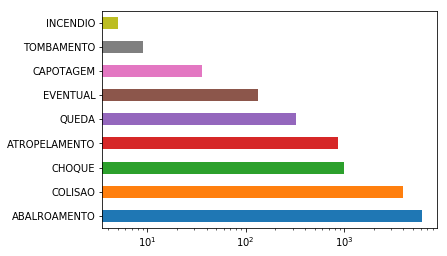

In [105]:
acident_type = acidents_data['TIPO_ACID'].value_counts()
acident_type.plot.barh(logx = True)

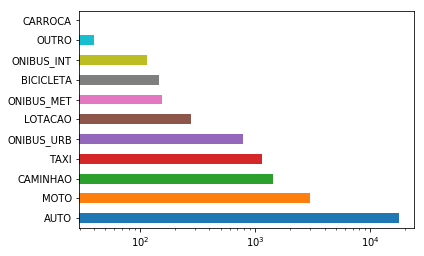

In [49]:
vehicle = acidents_data[[ 'AUTO', 'TAXI', 'LOTACAO', 'ONIBUS_URB', 'ONIBUS_MET', 'ONIBUS_INT',
       'CAMINHAO', 'MOTO', 'CARROCA', 'BICICLETA', 'OUTRO']].sum().sort_values(ascending=False)
vehicle.plot.barh(logx=True)

 Analise temporal dos acidentes

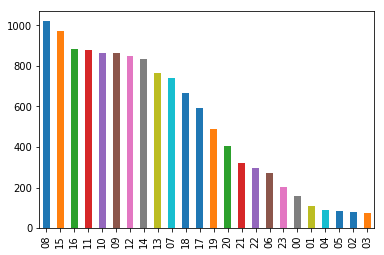

In [50]:
number_acidents_hour = acidents_data['HORA_ACID'].value_counts()
number_acidents_hour.plot.bar()

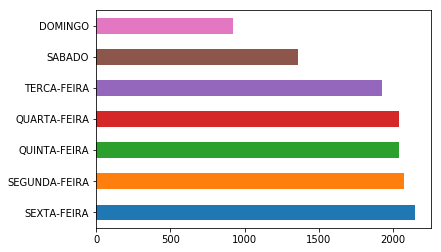

In [51]:
number_acidents_day = acidents_data['DIA_SEM'].value_counts()
number_acidents_day.plot.barh()

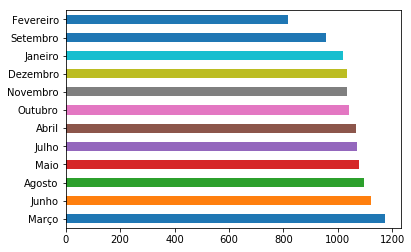

In [128]:
number_acidents_month = acidents_data['MES'].value_counts()
number_acidents_month.plot.barh()

Analise de pessoas envolvidas nos acidentes por regiões

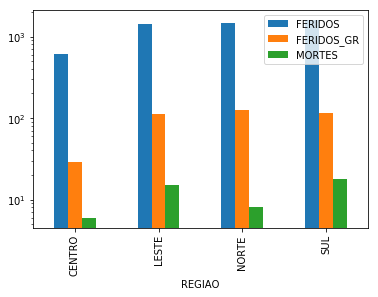

In [86]:
hurt_amount_region = acidents_data.groupby("REGIAO")[['FERIDOS', 'FERIDOS_GR', 'MORTES']].sum()
hurt_amount_region.drop(['NAO IDENTIFICADO']).plot.bar(logy=True)

### Hipótese: Existe uma relação entre a natureza do acidente com a quantidade de vítimas?

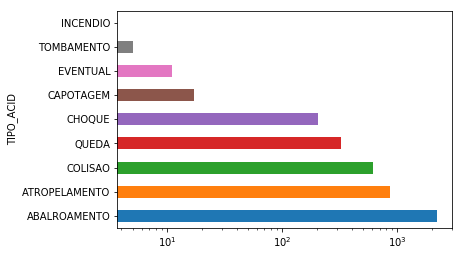

In [106]:
acident_type_vic = acidents_data.groupby("TIPO_ACID")['CONT_VIT'].sum().sort_values(ascending=False)
acident_type_vic.plot.barh(logx=True)